This notebook analyses the TED data-set from Kaggle. The data-set
can be obtained [here](https://www.kaggle.com/rounakbanik/ted-talks).
This notebook focuses on text-mining and demonstrates feature-extraction
(using Term Frequency - Inverse Document Frequency), Topic Modeling (using 
Latent Dirichlet Allocation) and Named Entity Recognition.

Useful insights are gathered including favorite words used by speakers,
different topics on which speeches are based, topic trends over time
and most used persons in speeches.

**Table of Contents:**

    1. Data Pre-processing
        1.1 Combining all the available data
        1.2 Data preprocessing for text analysis
        1.3 Create a Gensim corpus
    2. Text feature extraction
        2.1 Term Frequency - Inverse Document Frequency
        2.2 Conclusion
    3. Topic Modeling
        3.1 LDA
            3.1.1 LDA model visualization
        3.2 Tracking topic trends over time
            3.2.1 Visualization of topic trends
        3.3 Conclusion
    4. Named Enitity Recognition
        4.1 Obtaining entities from text
        4.2 Most mentioned persons
    5. Conclusion

# 1. Data Pre-processing

In [1]:
# Common packages required
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import re

%matplotlib inline

# Directory under which all data is stored
DATA_PATH = 'data'

# Global override settings
# If true, all the saved to disk data structures are re-computed
OVERRIDE_SETTINGS = False

# Number of Topics
NUM_TOPICS = 8

In [2]:
# Import required packages
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.utils import simple_preprocess
from gensim import corpora

## 1.1 Combining all the available data

The data from Kaggle has two CSV files.

1. ted_main.csv
2. transcripts.csv

The `prepare_dataset()` function does some preliminary pre-processing
such as adjusting the column types and merges these two csv files into one
and saves it to disk. Further runs can make use of these saved to disk
files instead of generating the merged data-set again.

In [3]:
def prepare_dataset(force=False):
    '''Prepare a dataset from the raw data 
    obtained from Kaggle and save it to disk'''
    
    # Check if a previously processed dataset exists
    # If the processed dataset file exists and force is set to False,
    # raw data is processed
    if not os.path.isfile(os.path.join(DATA_PATH, 'processed.pkl')) or force:

        # Read CSVs obtained from Kaggle
        transcripts_df = pd.read_csv(os.path.join(DATA_PATH, 'transcripts.csv'))
        ted_main_df = pd.read_csv(os.path.join(DATA_PATH, 'ted_main.csv'))
        
        # Filter columns that are not required
        ted_main_df = ted_main_df[['film_date', 'title', 'main_speaker', 'speaker_occupation','url']]
        
        # Convert columns where necessary
        ted_main_df['film_date'] = pd.to_datetime(ted_main_df['film_date'], unit='s')

        # Create one DataFrame from the two CSVs
        df = ted_main_df.merge(transcripts_df, on='url', how='inner')
        
        # The transcript text uses brackets to record expressions
        # and reactions such as (laughter), (applause) etc.
        # We'll use a regex to remove them
        df['transcript'] = df['transcript'].str.replace(r'\([0-9A-Za-z\s]+\)', ' ')
        df.to_pickle(os.path.join(DATA_PATH, 'processed.pkl'))
        
    else:
        # if the file exists
        df = pd.read_pickle(os.path.join(DATA_PATH, 'processed.pkl'))
        
    return df

## 1.2 Data preprocessing for text analysis

Preprocessing the data-set in the context of text mining involves
lower-casing, stemming, and vectorizing tokens in the text.

Also, tokens which are very commonly used or appear less frequently
in the data-set usually does not improve the model and they are (usually)
removed.

In [4]:
def tokenize(text):
    '''Remove stopwords, lowercase and tokenize words'''

    return [token for token in simple_preprocess(text) if token not in ENGLISH_STOP_WORDS]


def preprocess(df, force=False):
    '''Preprocess the dataset in the context of text-mining'''
    
    if not os.path.isfile(os.path.join(DATA_PATH, 'texts.pkl')) or force:
        # Tokenize each transcript (document in the context of LDA)
        docs = df.transcript.values
        texts = [tokenize(doc) for doc in docs]


        # Calculate frequency of each token
        frequency = defaultdict(int)

        for text in texts:
            for token in text:
                frequency[token] += 1


        # Remove tokens that appear less than 10 times in the corpus
        texts = [[token for token in text if frequency[token] > 10] for text in texts]
        
        with open(os.path.join(DATA_PATH, 'texts.pkl'), 'wb') as f:
            pickle.dump(texts, f)
            
    else:
        # Read the texts from the saved pickle file
        with open(os.path.join(DATA_PATH, 'texts.pkl'), 'rb') as f:
            texts = pickle.load(f)


    return texts

## 1.3 Create a Gensim Corpus

Here we create a dictionary and a corpus. A dictionary maps integer ids to tokens.
The corpus is a bag of words representation of the documents.

In [5]:
def gen_dictionary(texts, force=False):
    '''Create and save a gensim dictionary for the documents'''

    if not os.path.exists(os.path.join(DATA_PATH, 'dictionary.dict')) or force:
        dictionary = corpora.Dictionary(texts)
        dictionary.save(os.path.join(DATA_PATH, 'dictionary.dict'))
        
    else:
        # Read the saved dictionary from disk
        dictionary = corpora.Dictionary.load(os.path.join(DATA_PATH, 'dictionary.dict'))
        
    return dictionary

In [6]:
# create a corpus
def gen_corpus(texts, dictionary, force=False):
    '''Generate a gensim corpus from the texts'''
    
    if not os.path.isfile(os.path.join(DATA_PATH, 'corpus.pkl')) or force:
        corpus = [dictionary.doc2bow(text) for text in texts]
        
        with open(os.path.join(DATA_PATH, 'corpus.pkl'), 'wb') as f:
            pickle.dump(corpus, f)
            
    else:
        # Read the corpus from the saved pickle file
        with open(os.path.join(DATA_PATH, 'corpus.pkl'), 'rb') as f:
            corpus = pickle.load(f)
            
    return corpus

Run all the functions previously defined and create variables to use the results.

In [7]:
# Read the data-set
df = prepare_dataset(force=True)

# Create the documents
texts = preprocess(df, force=OVERRIDE_SETTINGS)

# Generate the dictionary and the corpus
dictionary = gen_dictionary(texts, force=OVERRIDE_SETTINGS)
corpus = gen_corpus(texts, dictionary, force=OVERRIDE_SETTINGS)

# 2. Text feature extraction

## 2.1 Term Frequency - Inverse Document Frequency

Here *Term frequency - inverse document frequency (tf-idf)* is used to
determine the most important words in a document. It is better than
the *bag-of-words* model as it **down-weighs importance of shared words
that are not stopwords**. That is, **document specific words are wieghed
high.**

It is the product of two terms:
1. **Term Frequency:** Frequency of a term in a document.
2. **Inverse-Document Frequency:** Number of documents that contain the term.

$$ tfidf_{i,j} = tf_{i,j} \times log(\frac{N}{df_{i}}) $$

$i$ = token index

$j$ = document index

$tfidf_{i,j}$ = tf-idf weight for token $i$ in document $j$

$tf_{i,j}$ = number of occurences of token $i$ in document $j$

$N$ = number of documents

$df_{i}$ = number of documents containing token $i$

In [8]:
# Import required packages
from gensim.models import TfidfModel

In [9]:
# Generate a tf-idf model from the corpus
tf_idf = TfidfModel(corpus=corpus, id2word=dictionary, normalize=True)
tf_idf_corpus = tf_idf[corpus]

In [10]:
# the tf-idf weights for each document in the corpus
tf_idf_weights = []

for doc in tf_idf_corpus:
    # the tf-idf weights of tokens in the document
    doc_tf_idf_weights = []
    
    for doc_id, value in doc:
        doc_tf_idf_weights.append([dictionary.get(doc_id), value])
        
    doc_tf_idf_weights_df = pd.DataFrame(doc_tf_idf_weights,
                                         columns=['token', 'importance'])
    tf_idf_weights.append(doc_tf_idf_weights_df)

## 2.2 Conclusion

We have the importance of each word in every document. The most important
words in a document will give us an idea of the main content of that document.

For example,

In [11]:
# Print out the 10 most important tokens in the 3rd transcript
tf_idf_weights[2].sort_values('importance', ascending=False).head(10)

,token,importance
406,microsoft,0.326365
217,software,0.283579
397,features,0.213557
263,mac,0.192150
343,apple,0.185652
459,simplicity,0.163930
364,technician,0.136743
452,windows,0.124464
282,column,0.109911
515,taps,0.106784


Since the most important tokens in this speech relate to software and
technology, the TED talk can be concluded to be related to software.

# 3. Topic Modeling

A topic model aims to discover the "topics" that occur in a set of documents.
Topic modeling uses statistics for discovering hidden semantic structures in
a text body.

## 3.1 LDA

LDA (latent Dirichlet allocation) is one technique used for topic modeling.

In [12]:
# Import required packages
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim

In [13]:
# Create the LDA Model
def gen_lda_model(corpus, dictionary, force=False):
    '''Generate the LDA model from the corpus and the dictionary'''
    
    if not os.path.isfile(os.path.join(DATA_PATH, 'lda_model.mdl')) or force:
        topics = LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=NUM_TOPICS,
                          passes=10)
        
        topics.save(os.path.join(DATA_PATH, 'lda_model.mdl'))
        
    else:
        # Read the model from file
        topics = LdaModel.load(os.path.join(DATA_PATH, 'lda_model.mdl'))

    return topics

In [14]:
topics = gen_lda_model(corpus, dictionary, force=OVERRIDE_SETTINGS)

### 3.1.1 LDA Model Visualization

Here, the pyLDAvis library is used to visualize tokens that make up a topic.

For identifiying the tokens that make a topic, setting the relevance metric
in the visualization to 0.2 is found to be ideal.

In [15]:
vis_data = pyLDAvis.gensim.prepare(topics, corpus, dictionary)
pyLDAvis.display(vis_data)

## 3.2 Tracking topic trends over time

Here, frequencies of the topics are plotted against time.
This graphs gives us a general idea about how topics trend
over time.

In [16]:
# Extract all document-topic distritbutions to dictionnary

# Use the index as key, so columns can be easily added later
doc_key = list(df.index)
doc_topic = {}

for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = topics.get_document_topics(docbok, 0)
    
    tmp = []
    
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    
    doc_topic[doc_key[doc_id]] = tmp

In [17]:
# Convert dictionary of document-topic distritbutions to dataframe
doc_topic_df = pd.DataFrame.from_dict(doc_topic, orient='index')

doc_topic_df['year'] = df.film_date.dt.year
topic_column_names = ['topic_{}'.format(i) for i in range(1, NUM_TOPICS + 1)]
topic_column_names.append('year')
doc_topic_df.columns = topic_column_names

doc_topic_df.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,year
0,0.000106,0.421993,0.072783,0.109100,0.004768,0.376857,0.000106,0.014287,2006
1,0.375798,0.302354,0.000154,0.000191,0.073972,0.076526,0.086619,0.084385,2006
2,0.004055,0.663023,0.022701,0.016219,0.000095,0.069956,0.210084,0.013868,2006
3,0.242222,0.000091,0.000091,0.474857,0.043595,0.074136,0.030442,0.134566,2006
4,0.721752,0.122654,0.000107,0.016168,0.000107,0.000107,0.123897,0.015209,2006


### 3.2.1 Visualization of Topic Trends

The topic frequency for each year is computed and plotted in a graph.

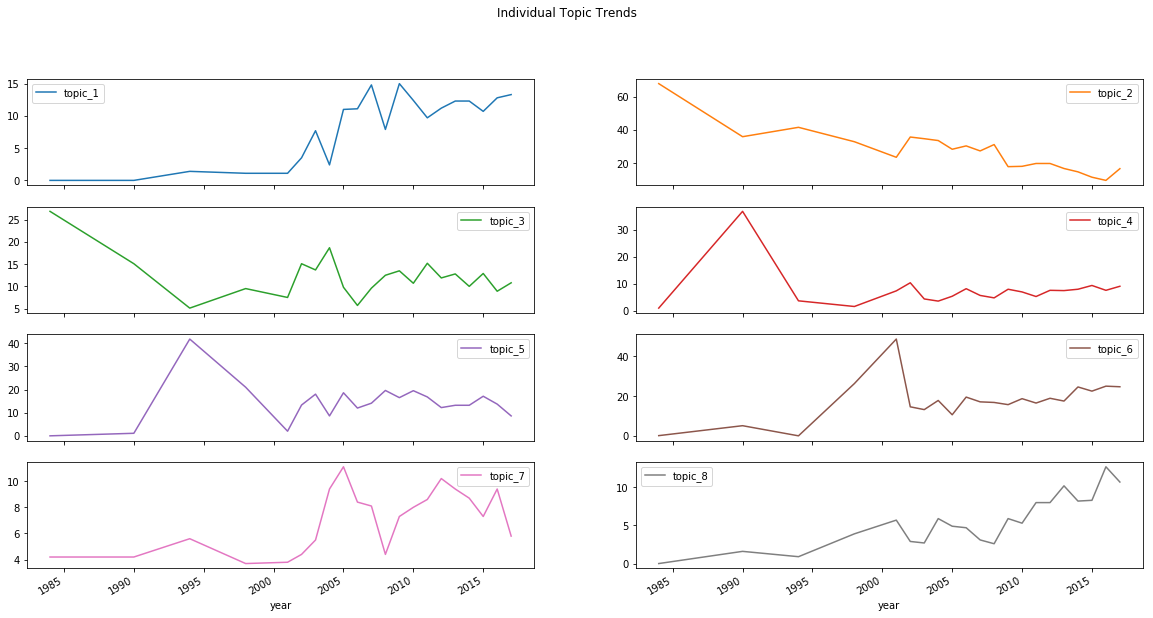

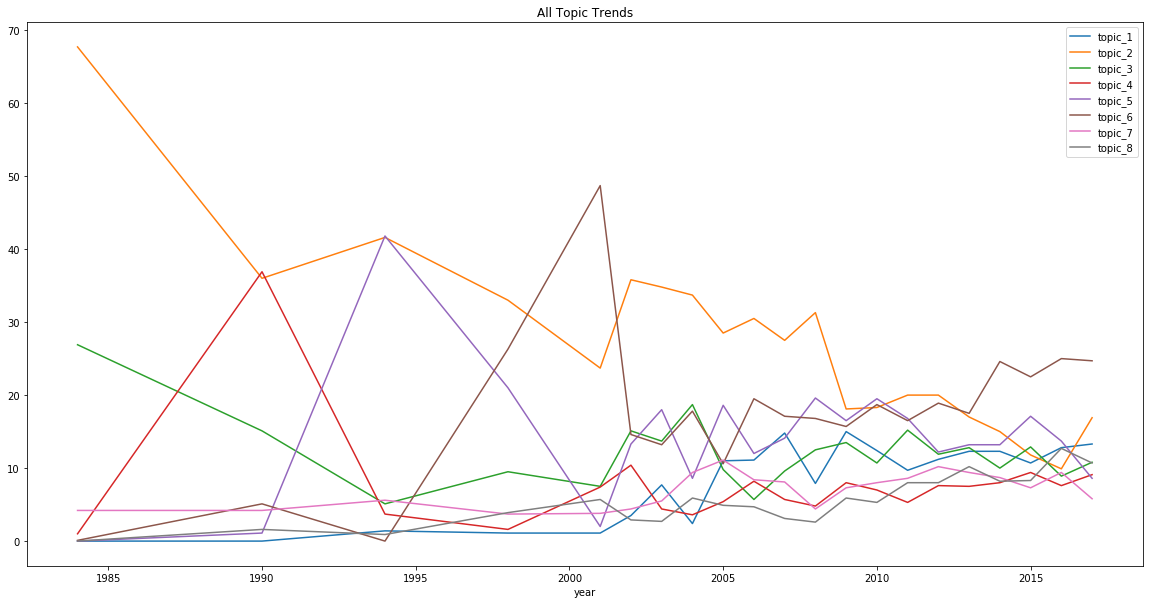

In [18]:
# topic columns to process
columns = ['topic_{}'.format(i) for i in range(1, NUM_TOPICS + 1)]

# Create a topic frequency DataFrame
topic_freq = pd.DataFrame(doc_topic_df.groupby('year')[columns].sum())

# Normalize the DataFrame
topic_freq = 100 * topic_freq.div(topic_freq.sum(axis=1), axis=0)
topic_freq = np.round(topic_freq, 1)

# Plot topic trends
topic_freq.plot(subplots=True, layout=(int(NUM_TOPICS / 2), 2), figsize=(20, 10),
               title='Individual Topic Trends')

topic_freq.plot(figsize=(20, 10), title='All Topic Trends')

## 3.3 Conclusion

From the LDA visualization, the tokens that make up a topic can be determined.

For example, topic_4 consists of the tokens *countries, global, poverty, economics,
economics and gdp*, topic_4 is regarding demographics and economics. Talks on this
topic have been consistent in number over the last few years.

Similarly, topic_6 can be interpreted as being related to technology (the occurence
of the tokens *data, blockchain, bitcoin, patent*) Talks on this topic have been 
increasing as seen from the trend visualization.

# 4. Named Entity Recognition

Named Entity Recognition (NER) classifies named entities in text
into pre-defined categories such as the names of persons, organisations etc.

## 4.1 Obtaining entities from text

The *spacy* library provides neural models for tagging, parsing and entity
recognition. Here the *English Language* model `en_core_web_sm` is used.

In [19]:
# Import packages for named entity recognition
import spacy

# Load the 'en' model
nlp = spacy.load('en')

In [20]:
def construct_entity_list(docs, force=False):
    '''Construct a dictionary of entities in the docs'''
    
    if not os.path.isfile(os.path.join(DATA_PATH, 'entity-list.pkl')) or force:
        
        print('Generating the entity dictionary')
        
        entities = defaultdict(list)

        for i, doc in enumerate(docs):

            if i % 50 == 0 or i == len(doc) - 1:
                print('Done {:>4}/{:4}'.format(i, len(docs)))

            for ent in nlp(doc).ents:
                entities[ent.label_].append(str(ent))
                
        # Write the enitity dictionary to disk
        with open(os.path.join(DATA_PATH, 'entity-list.pkl'), 'wb') as f:
            pickle.dump(entities, f)
                
    else:
        # Read the enitity dictionary from disk
        print('Reading the entity dictionary from disk')
        
        with open(os.path.join(DATA_PATH, 'entity-list.pkl'), 'rb') as f:
            entities = pickle.load(f)
            
    return { k: set(v) for k, v in entities.items() }

In [21]:
# Create the list of documents
docs = df.transcript.values

entities = construct_entity_list(docs)

Reading the entity dictionary from disk


In [22]:
# Diffent types of entities and a few examples of each entity

for ent, examples in entities.items():

    print('{:12} : {}'.format(ent, ', '.join(random.sample(list(examples), 3))))

TIME         : Just a few more minutes, less than half an hour, just the dawn
CARDINAL     : 220-foot, nearly 1,000, six to eight
ORDINAL      : Thirdly, 150th, 30th
DATE         : the past 200 years, about three billion years, just 15 years
ORG          : Acheulian, the Beveridge Report, My Life So Far
LOC          : K-T. A 10-kilometer, Scandinavia, Earth Mars
PERSON       : Zeinab, Ghiberti, John Sosoka
PRODUCT      : the Solar System, Cylons, Airplane
GPE          : The State of Connecticut, Lampoon, Mango
LANGUAGE     : Britannica, C++, no?SJ
WORK_OF_ART  : the Large Hadron Collider, Happy Birthday, the Amsterdam Prize for the Arts
FAC          : Art Center, Classic, Washington Square Park
QUANTITY     : about 200 nautical miles, only 40 miles, 1.2 and
NORP         : South Korean, Hovering, Prussian
LAW          : The High Line, Day three, Doaa, Charter
MONEY        : eight to 10 dollars, 700,000, 13.7 billion light years
PERCENT      : zero to 30 percent, only about 1.5 percent, 

## 4.2 Most mentioned persons

In [23]:
# Remove the characters '—', "'s", '♫ ♫'
names = list(map(lambda x: x.replace('—', '').\
                 replace("'s", '').\
                 replace('♫ ♫', ''),
                 entities['PERSON']))

# Persons with a first name and a last name
names_subset = list(filter(lambda x: len(x.split()) > 1, names))

# Remove duplicates
names_subset = list(set(names_subset))

In [24]:
persons_count = []

# Total number of names
total = len(names_subset)

for i, person in enumerate(names_subset):

    count = df[df.transcript.str.contains(re.escape(person), re.I)].shape[0]
    persons_count.append([str(person), count])
    
    # Print progress
    if i % 500 == 0:
        print('Done {:>4}/{:4}'.format(i, total))

Done    0/6473
Done  500/6473
Done 1000/6473
Done 1500/6473
Done 2000/6473
Done 2500/6473
Done 3000/6473
Done 3500/6473
Done 4000/6473
Done 4500/6473
Done 5000/6473
Done 5500/6473
Done 6000/6473


In [25]:
# Create a DataFrame of the counts
persons = pd.DataFrame(persons_count, columns=['name', 'count'])

# Top 10 names
persons.sort_values('count', ascending=False).head(10)

,name,count
33,Chris Anderson,151
2040,TED Talk,63
4014,Bill Gates,48
5369,Al Gore,46
2370,Bruno Giussani,44
5623,Martin Luther,38
4167,Martin Luther King,34
3941,Nelson Mandela,28
5016,the Big Bang,28
2056,Charles Darwin,27


The most mentioned persons in TED talks include Chris Anderson,
Bill Gates, AL Gore, Bruno Giussani, Martin Luther King, Nelson
Mandela and Charles Darwin.

# 5. Conclusion

In this notebook, Transcripts from TED talks obtained from Kaggle,
1. Are preprocessed for text analysis
2. The most important words in a transcipt are obtained using tf-idf
3. The major topics of the transcripts are estimated using LDA for topic modeling
4. The topic model is visualized and trends of topics across time is also visualized
5. Named Entity Recognition identifies entities and is used to identify the most popular persons in a TED talk